# Import

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [4]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [5]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

In [6]:
from ReBADD_config import Reward_gsk3_jnk3_qed_sa as Reward
#from ReBADD_config import Reward_gsk3_jnk3 as Reward
#from ReBADD_config import Reward_jnk3 as Reward
#from ReBADD_config import Reward_gsk3 as Reward

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = 'outputs_0_preprocess_data'
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = 'outputs_2_optimize'
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 295601
Number of vocabulary: 34620
Maximum of seqlen: 34


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 40,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

## 2-1) RL design

In [13]:
my_reward_ft = Reward()

[DEBUG] GSK3(8515) = 0.740
[DEBUG] JNK#(8515) = 0.670
[DEBUG] QED(8515) = 0.495
[DEBUG] SA(8515) = 2.127


In [14]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft, zeta=0.9999)

## 2-2) Training

In [15]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [16]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [17]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [18]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [19]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                  gsk_list, jnk_list, qed_list, sa_list,
                  execution_times, filepath):
    
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "GSK3":gsk_list,
                               "JNK3":jnk_list,
                               "QED":qed_list,
                               "SA":sa_list,
                               "EXEC_TIME":execution_times})
    
    df_history.to_csv(filepath, index=False)
    return df_history

In [20]:
# Setting up some parameters for the experiment
n_iterations = 1000
checkpoint_stepsize = 50
behavior_stepsize = 20

[0001] rl_loss: 0.987	reconst_loss: 0.912	entropy_loss: 0.075	reward: 0.415	tau: 0.301	(30.633 sec)
[0002] rl_loss: 0.863	reconst_loss: 0.776	entropy_loss: 0.087	reward: 0.396	tau: 0.301	(60.735 sec)
[0003] rl_loss: 1.186	reconst_loss: 1.095	entropy_loss: 0.091	reward: 0.546	tau: 0.304	(91.325 sec)
[0004] rl_loss: 1.020	reconst_loss: 0.923	entropy_loss: 0.097	reward: 0.464	tau: 0.304	(121.804 sec)
[0005] rl_loss: 0.816	reconst_loss: 0.707	entropy_loss: 0.109	reward: 0.482	tau: 0.304	(152.160 sec)


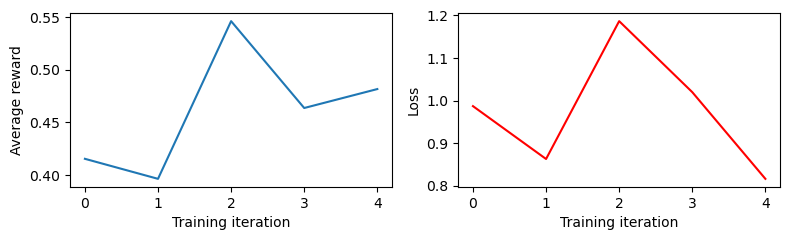

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.81it/s]


Sample trajectories: 100
[0.010, 0.010, 0.627, 4.018]    COC=CC(C)=C1SC=CC1=C
[0.040, 0.000, 0.449, 2.862]    NC(=S)N1N=C(C2=CC=CC=C2)CC1C3=CN(C4=CC=CC=C4)N=C3C5=CC=C(F)C=C5
[0.010, 0.000, 0.214, 4.037]    CC=C(C1=CC=CC=C1)NC(=S)CCSC=CC=CN2CC=C=CC3=CC=CC=C32
[0.010, 0.000, 0.813, 2.211]    CC1=CC=CC(C)=C1NC(=O)C(=O)C(F)(F)F
[0.150, 0.070, 0.743, 2.031]    CC1=C(C)C2=C(NC3=CC=C(Cl)C=C3)N=CN=C2S1
[0.260, 0.050, 0.785, 3.548]    CCCCNC(=O)N(C1C(C)C)C=CC2=C(C3=CC=NC=C3)NC=C21
[0.260, 0.040, 0.275, 3.147]    COC(=O)NC(CCS)C(=O)NC(CCCCN)C(=O)NC1=CC=NC=C1
[0.420, 0.050, 0.749, 5.234]    NC1=NC=NC2=CC=NC=C1C3CCC3=NCCCCNCCN=C2
[0.060, 0.030, 0.684, 4.772]    CCC1CCOC=CC(NCC2=CC=C(Br)C=C2)N=CC=CC=C(O)N1
[0.080, 0.010, 0.338, 4.536]    CC(=O)OCC=CC=C=CCCCC1OC=NC(C)=C1N
[0.040, 0.010, 0.250, 3.178]    COC1=CC=CC=C1OC2=CC=C3C(=O)C=C(C3=C2)C(Br)=C(Cl)C(Br)=CC=O
[0.010, 0.010, 0.627, 2.282]    CON=C(C1=CC=CC=N1)C2=CC=CC=C2CN3CCCCC3
[0.060, 0.000, 0.461, 5.459]    C(O)#CC(Br)C=C(Br)C=CN
[0.020, 0.000,

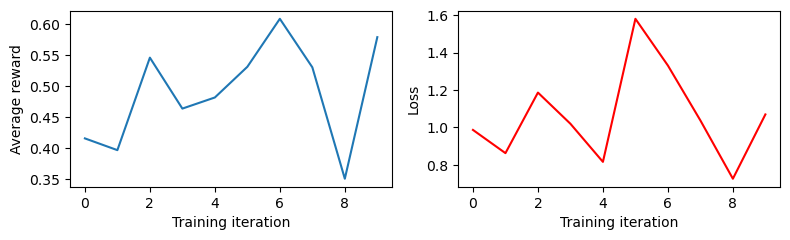

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.81it/s]


Sample trajectories: 100
[0.010, 0.020, 0.779, 3.144]    O=C(C1=CC=CN1)N(C2CCC(=O)NC2=O)CCN3CCCCC3
[0.070, 0.010, 0.151, 4.054]    CCCOC=CC=COC(CF)C=NC1=CC=CC=C1C=NCC2=CC=C(Br)C=C2
[0.030, 0.000, 0.792, 3.190]    COC1=CC=C2C=C(NC2=C1)C(CO)N(C)C(=O)NC
[0.010, 0.010, 0.707, 2.626]    O=C(C=C1C=CC2=CC=CC=C2)CO1
[0.000, 0.000, 0.523, 6.892]    C12OC=CC=C=NS1C=C2
[0.200, 0.080, 0.760, 3.780]    COC1=CC=C2C=C1C3=CNC(NC4=CC=C(Cl)C=C4)=NC3=N2
[0.010, 0.000, 0.499, 3.050]    CCCNCCC=NC(N1CCCCC2=CC=CC=C2)=CO1
[0.150, 0.030, 0.521, 3.333]    O=C1NC(=O)N(CC(F)(F)F)C(=O)C1=C2C=CN(C(=O)OC(C)(C)C)CC2=O
[0.000, 0.000, 0.775, 2.325]    CN1CCCC1C2=CC=CC(C3=CC=CC(F)=C3)=C2
[0.000, 0.130, 0.529, 1.904]    O=C(C=CC1=CC=CC(Cl)=C1)NC2=CC=CC([N+1](=O)[O-1])=C2
[0.180, 0.060, 0.739, 3.561]    CN(C)CCNC=C1C(C2=CNN=C2)=CN=C1
[0.080, 0.050, 0.492, 3.437]    NC1=NC(CO1)CC(=O)NCCCCCCN=C(C)C
[0.000, 0.000, 0.873, 2.770]    CCN1CCC2(CC1)C(=O)NCN2C3=CC=CC=C3
[0.090, 0.010, 0.874, 4.958]    CC(C)C1NC=CC(CCC2=C3C=CC=C2)

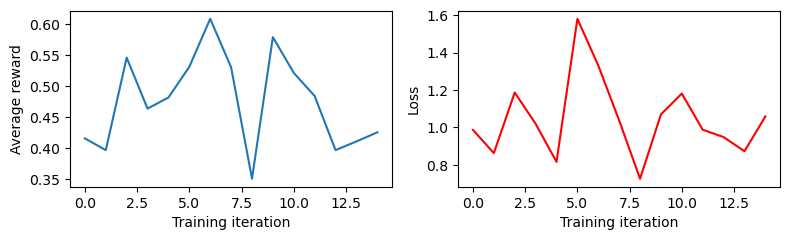

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 178.11it/s]


Sample trajectories: 100
[0.010, 0.010, 0.642, 4.900]    C1=C2C=C1NC(=O)N(C)C(C)(C)N=C2C
[0.160, 0.080, 0.807, 3.347]    COC=C1C(OC)=C2C(=O)C=C(C3=CC=CC(Cl)=C3F)OC2=C1
[0.010, 0.000, 0.834, 2.867]    CN1CCN(C2=CC=C(F)C=C2)C(=O)C1CCN(C)C
[0.020, 0.040, 0.848, 2.432]    O=S(=O)(CC1=CC=CC=C1)NC2=C(CN3CCOCC3)C4=CC=CC=C42
[0.000, 0.010, 0.553, 4.138]    CNC1CCCCC1C(=O)CCC(=O)N=CC=CC=CCC
[0.010, 0.010, 0.768, 3.170]    COCC(=O)C1=CC2=C(S1)C(OC)=C(OC)O2
[0.080, 0.030, 0.748, 3.416]    O=C(NC1=CC=CC(F)=C1)C2=C(O)CCNC2=NC=CC=CC
[0.020, 0.000, 0.696, 1.830]    CCC(=O)C1=CNC2=CC=CC=C12
[0.030, 0.000, 0.750, 3.792]    CC(C)CN1C=CC(C#N)=C(N)C1(C)C
[0.020, 0.030, 0.427, 6.263]    C12OC=CC=C=[N+1]1C=C2
[0.000, 0.120, 0.486, 2.312]    O=C(CNC1=CC=CC=C1)NN=CC2=CC=C([N+1](=O)[O-1])S2
[0.010, 0.120, 0.360, 1.822]    NC1=CC=CC([N+1](=O)[O-1])=C1
[0.220, 0.080, 0.735, 2.540]    O=C1NC(C2=CC=CC=C2)=NC1=CC3=CC4=CC=CC=C4O3
[0.080, 0.030, 0.647, 3.604]    N1C=NC(N)=C(N=O)C(C2=CC=CC=C2O)=N1
[0.000, 0.020, 0.747

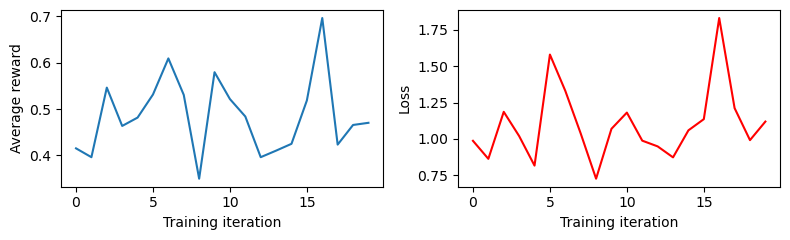

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.46it/s]


Sample trajectories: 100
[0.000, 0.000, 0.281, 3.923]    O1CO1
[0.010, 0.000, 0.594, 3.125]    CCOC(=O)C(NC(C)=O)C(=O)OC(C)C1=CC=C(C2=CC=CS2)C=C1
[0.000, 0.000, 0.881, 1.429]    O=C(O)C1=CC=CC=C1C(=O)NCC2=CC=CC=C2
[0.010, 0.010, 0.477, 2.507]    COC(=O)C(CC1=CC=CS1)NC(=O)C2=CC=C(OCCCC(=O)O)C=C2
[0.010, 0.020, 0.840, 4.739]    C1C=NC2=NC=NN2C=CC(C#N)=C1CC3CCCN(C)C3
[0.080, 0.040, 0.466, 5.014]    CCC(O)N=COC=CC(OC)C=C(C1=C2C=NC=C1F)OCO2
[0.050, 0.010, 0.833, 4.860]    OC1CCCC2C1C=C(OC)C=C(OCCO)C=CS2
[0.000, 0.000, 0.366, 4.433]    S(=O)(=O)N(C)NC(=O)CS
[0.090, 0.040, 0.338, 4.777]    C1C(=O)CC=CCCCS1C(=O)N(C)C=CC=C(C(F)(F)F)C2=CC=NC=CC=CC=C2
[0.170, 0.030, 0.554, 4.804]    CCOC(=O)C=C(C=NO1)NCC2C=CC(C3=CC=C4OCOC4=C3)=CC=CC(=O)OC=C12
[0.100, 0.020, 0.732, 3.332]    CCC1CCC(=O)OC1CC2=CC=CC=N2
[0.030, 0.000, 0.907, 3.234]    OC(CC1CCCCN1)(C2=CC=C(Cl)C=C2)C3=CC=CC=N3
[0.010, 0.020, 0.809, 1.916]    CCC1=CC2=CC=CC=C2C=C1NC3CC3
[0.070, 0.040, 0.767, 3.529]    COC(=O)C1C=C(C2=CSC=C2)SC(C3=CC=C

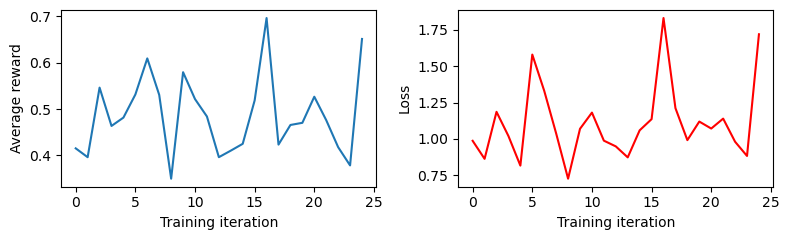

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.07it/s]


Sample trajectories: 100
[0.000, 0.000, 0.769, 3.003]    CCOC(=O)C1=CCCCC1S(=O)(=O)C2=CC=C(C(F)(F)F)C=C2
[0.070, 0.020, 0.686, 4.892]    COC=CC=CC1=C(NC(=O)C2CCCN23)CC4=CC=CC=C4N13
[0.020, 0.000, 0.556, 1.733]    NC1=CC=C(F)C=C1Cl
[0.030, 0.030, 0.902, 2.884]    O=C(CCC1=CC=CC=C1)C2=CC=CC(C3=CC=CC=C3)N2
[0.090, 0.020, 0.714, 1.967]    OC1=CC=CC(C2=CN=CN=C2)=C1
[0.120, 0.020, 0.323, 3.711]    ONCC1CCCCC1C2=CC=C3C(=C2)C=CC4=C3NN=C4C#CC5=CC=CC=C5
[0.010, 0.010, 0.537, 3.159]    NC(=O)CCCCCCNC1=NC=C(CCO)C1
[0.000, 0.000, 0.757, 1.807]    COC1=CC=C(S(=O)(=O)O)C=C1NC(=O)COC2=CC=C(Cl)C=C2
[0.000, 0.010, 0.248, 2.536]    COC=C(C(=O)OC)C1=CC=CC=C1CON=C(C)C2=CC=CC(F)=C2
[0.070, 0.010, 0.366, 3.884]    CCC(C)CC(=O)NC(CO)C(N)C(N)C(=O)O
[0.080, 0.020, 0.650, 2.338]    O=C(O)C1=CC2=C3C=CC=CC3=NC2=CN1
[0.080, 0.020, 0.326, 3.362]    CC(C)C=CCOC1=NC=NC=C1C=CC=CC=O
[0.030, 0.010, 0.646, 4.041]    C1CC2NC1C(=O)C3=CC=CC=C32
[0.020, 0.000, 0.455, 4.043]    O=CC(O)(Cl)C(F)(F)F
[0.030, 0.010, 0.480, 4.334] 

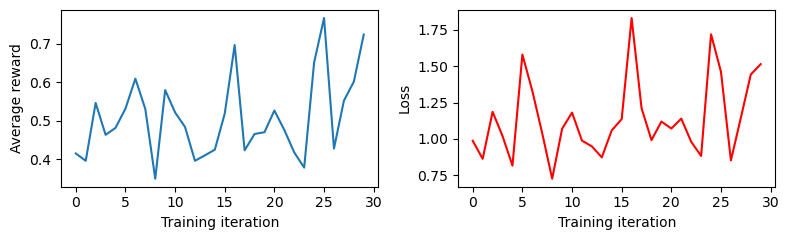

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.87it/s]


Sample trajectories: 100
[0.120, 0.000, 0.765, 4.438]    C12C3=CC=CNC=C1CC2(NC4=CC=CC(O)=C4)N=C3CCCC
[0.110, 0.010, 0.539, 4.927]    CCC(C1)CCC=C(C(=O)O)OC12NC=C(C(N)=O)C(=O)N2
[0.060, 0.020, 0.581, 4.973]    C12C=NN=CCC=C1N=C3C=CC=CN23
[0.060, 0.050, 0.406, 2.966]    C=CCOC(=O)C(Cl)=C(C#N)C1=NC2=CC=CC=C2N1
[0.290, 0.020, 0.595, 2.694]    OC1=NC(C2=CC=NC=C2)=NC3=C1N=NN3NC4=CC=CC=C4
[0.030, 0.000, 0.219, 6.271]    COC=CC=CC(COCC1CC2OCC1)C(=O)OC23CC(=O)C(C4=CC=CC=C43)(C5=CC=CC=C5)C6=CC=CC=C6
[0.040, 0.010, 0.832, 3.769]    CCCCN1C=C2N=C1C(=O)C=C(NC3=CC=C(O)C=C3)C2
[0.030, 0.010, 0.352, 2.947]    CCSC(=O)CCNC=CC(=O)C1=CC(F)=C(C(F)(F)F)C=C1
[0.100, 0.030, 0.423, 4.491]    COC=C1C=NCN2C=NNC=CC=NC(NCCCCCN3CCCC3)=C2C=C1OC
[0.000, 0.010, 0.533, 2.691]    CC(=O)C1=CSC=N1
[0.060, 0.000, 0.748, 2.064]    OC1=CC=CC=C1OC2CCNCC2
[0.050, 0.000, 0.898, 4.064]    CN(CCC1=CC=CC=N1)C(=O)N2CC3CCC(C2)N3
[0.010, 0.000, 0.546, 4.498]    C1=CS1N2CCOCC2
[0.000, 0.000, 0.601, 1.955]    COC1=CC=CC(C)=C1C(=O)C=CC

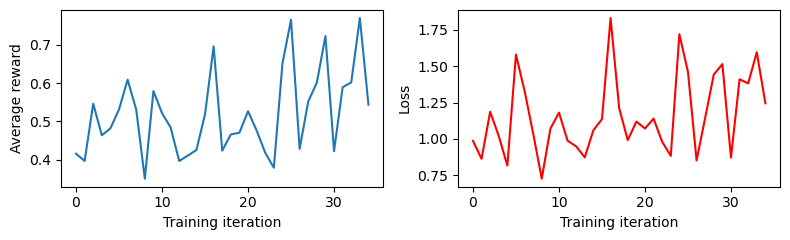

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.79it/s]


Sample trajectories: 100
[0.050, 0.000, 0.565, 1.894]    C1C(=O)NC2=CC=CC=C21
[0.060, 0.000, 0.761, 1.921]    CCN(CCC1=CC=CC=C1)C(=O)C2=CC3=CC=CC=C3N2
[0.230, 0.080, 0.507, 4.525]    O=COCCC=C1NCC(CO)C(C2=CC(N)=NC=N2)C1
[0.360, 0.110, 0.795, 2.110]    NC1=CC=C2N=CN=C(NC3CCCCC3)C2=C1
[0.040, 0.000, 0.657, 2.408]    COC1=CC=C(F)C2=C1CCC(=O)C2=O
[0.330, 0.220, 0.636, 2.333]    O=C1NC(=S)SC1=CC2=CC=C(C(F)(F)F)C=C2
[0.110, 0.020, 0.880, 3.145]    CC(C(=O)O)C1=CC=C(Cl)C(C2=CNC=N2)=C1
[0.080, 0.070, 0.787, 3.853]    CN(C)C1=NC=NC2=C1N=CN2C3OC(CO)C(O)C3F
[0.000, 0.000, 0.639, 2.371]    O=CNC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1
[0.040, 0.010, 0.647, 4.531]    O=C1NC=CC=CN=CCC(=O)CC1C
[0.140, 0.010, 0.557, 3.557]    NC1=C2NN=C1CC3=CC=CC=C3C2
[0.040, 0.020, 0.671, 2.501]    O=CC1=CC(C2=CC=CC=C2)=NN1C3=CSC=C3
[0.070, 0.040, 0.493, 6.460]    CCC=NN=CC1=CC(N2C3CCCC2)NCC=NC=C=C13
[0.000, 0.020, 0.652, 3.821]    O=C(O)C=C1C=C(SCCO)N=C1
[0.000, 0.000, 0.380, 5.939]    N1=CN1C[O-1]
[0.050, 0.000, 0.831, 3.575

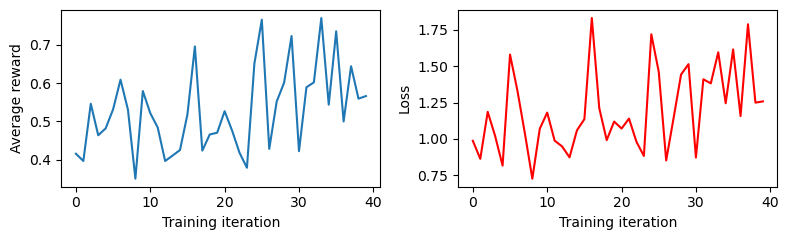

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.42it/s]


Sample trajectories: 100
[0.070, 0.060, 0.655, 3.578]    C1=NC(NCCC2=CNC=N2)=N1
[0.030, 0.000, 0.367, 2.680]    O=CNCNC1=CC=CC=N1
[0.040, 0.010, 0.745, 3.680]    C1=CC2=CC(=C1)NC(CCC3CCCCC3)CN2C4=CC=CC=C4
[0.050, 0.010, 0.612, 5.153]    O1CC=C(F)N=CCC=NN=CN=C1O
[0.010, 0.000, 0.770, 1.992]    CC(=O)CC1=C(C)NC2=CC=CC=C12
[0.220, 0.010, 0.712, 4.109]    O=S(=O)(CC1C2CCO1)C3=CN=CC=C3N2
[0.000, 0.000, 0.515, 2.306]    CCC1(CC)CCC1
[0.040, 0.040, 0.930, 1.955]    CC(C)(C)CNS(=O)(=O)C1=CC=CC=C1C2=CC=C(F)C=C2
[0.000, 0.000, 0.832, 2.437]    CCC(CC)NC(=O)C1=NOC(C2CC2)=C1
[0.000, 0.000, 0.832, 2.785]    CCC(C1=CNC2=CC=CC=C12)OC(=O)C(C)C
[0.070, 0.020, 0.497, 6.061]    CCC1(O)C(=O)OC2C3=C1C=C4C=NC5=CC6=C(CCCCC6)C=C5CCCC3C4=C2O
[0.060, 0.060, 0.340, 2.611]    CCOC(=O)C1=CC=C(N2N=CC(=O)NC2=O)C=C1C(=O)C=O
[0.090, 0.170, 0.256, 3.144]    O=C(C=C1SC(=O)NC1=O)CC(=O)NO
[0.260, 0.030, 0.666, 3.984]    C12OC3=CC4=C(C=NN4)C=C3C=C1S2
[0.020, 0.030, 0.794, 4.121]    CC1=CC=CC=C1C(=O)NC(=O)CS2C=CC=C(CN3C=CC=

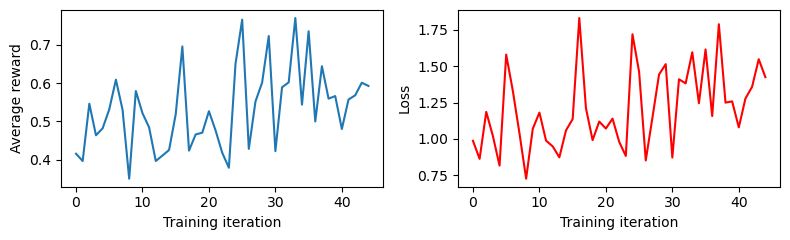

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.59it/s]


Sample trajectories: 100
[0.020, 0.000, 0.867, 2.953]    CCOC(=O)C1=C(Br)C(=O)NCC1C2=CC=CC=C2
[0.090, 0.030, 0.649, 3.181]    CN(C)C=CC(=O)C=C1C(C(=O)NCCN(C)C)=NC(NC2=CC=C(C)C=C2)=N1
[0.000, 0.010, 0.615, 2.287]    CCN(CC)C1CCOCC1
[0.010, 0.010, 0.497, 3.498]    CC(C)(NCCCC1=CC=CC=C1)CC2CCCCCCCCCCCC=N2
[0.040, 0.070, 0.749, 1.803]    C1=CC=C(NC2CCCCC2)N=C1
[0.150, 0.010, 0.727, 4.943]    C1CC2C3=CC(=O)OC=C3C(=O)NC(C=C1)=N2
[0.020, 0.010, 0.369, 3.449]    O=CC1=CC=CC=C1OC=C(Cl)C=CC=N
[0.010, 0.050, 0.623, 1.897]    COC1=CC=CC=C1N(C)C2=CC=C([N+1](=O)[O-1])C=C2
[0.060, 0.040, 0.746, 3.747]    O=C=CCNN1C=NNC(=O)N1C2=CC=CC=C2
[0.030, 0.030, 0.451, 2.268]    NNC1=CC=C(Br)C=C1C2=CC(Cl)=CC=C2N
[0.000, 0.000, 0.434, 2.645]    C=C(C(=O)N1CCOCC1)OC
[0.020, 0.010, 0.555, 5.582]    C12SC=NC=CC=CN=C1C=C2
[0.040, 0.030, 0.401, 2.565]    CN(CC1=CC=CN=C1)C(=O)CCC(=O)N(CC2=CC=CC=C2F)OCC3=CC=CC=C3Cl
[0.050, 0.030, 0.912, 3.060]    C1NC(=O)CC(C2=CC=CC=C2)C1C=CC3=CC=CC=C3
[0.010, 0.000, 0.425, 4.715]    CO

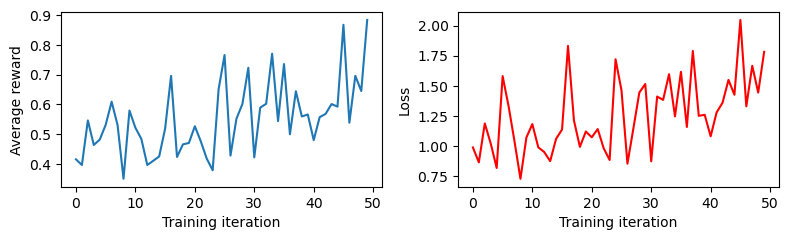

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.32it/s]


Sample trajectories: 100
[0.090, 0.000, 0.715, 3.345]    NC1=NC=NN1CCC(=O)N(C2CCOCC2)C=O
[0.030, 0.010, 0.733, 2.376]    N#CC(=CC1=CC=CN1)C2=CC=CC=C2
[0.000, 0.040, 0.215, 5.165]    O=C(O)C=CN=C(S)NC=CC=CN=CN=CN=C
[0.010, 0.000, 0.613, 2.110]    CC1=CC(Cl)=C(C)C(O)=C1
[0.220, 0.000, 0.759, 2.831]    CCSC1=C(C#N)C=C(C2=CC=NC=C2)O1
[0.150, 0.000, 0.562, 2.370]    N#CC1=CC=C(CN2C=NC=N2)C=C1C3=NC(C4=CC=CC=C4)=CS3
[0.100, 0.010, 0.795, 4.135]    OC(C(F)(F)F)C=CC=CCC(C1=CC=NC=C1)C2CCCOC2
[0.090, 0.100, 0.595, 3.168]    CCCC(=O)C1=CC(NC2=CN=C(O)N=C2O)=NC3=C1OC(=O)C=C3
[0.060, 0.020, 0.776, 4.814]    CC1CC1C(=O)OC2C=CC(=O)NN=C(C3CCCCC3)NC2
[0.010, 0.030, 0.709, 2.987]    CC1=CC=C(C=C1C)NC(CC2=CC=CC=C2Br)C(=O)N(CC)C=O
[0.010, 0.010, 0.816, 3.133]    CC(C)C1CN(C)CCC1C2=CC=C3OCOC3=C2
[0.070, 0.020, 0.756, 5.605]    ON1CCN(CC)C2CC1NC=CC=C(F)COCCOC2
[0.030, 0.010, 0.759, 3.052]    O=C(NC1=CC(Cl)=CC=C1O)C2=NN(C3CCS(=O)(=O)C3)C4=C2CCCC4
[0.190, 0.060, 0.597, 2.762]    O=C(COP(=O)(O)O)C1=CN(C2CCCCC2)N

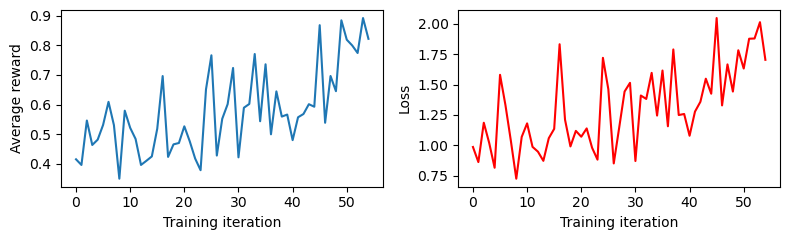

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.50it/s]


Sample trajectories: 100
[0.010, 0.000, 0.755, 1.998]    CC1=CC=CC=C1NCCN(CC2CC2)CCC
[0.170, 0.070, 0.394, 3.594]    COC=C1C(CCN)=CC=C1CC=C(O)NOC2=CC=C(Cl)C=C2C3=CC=CN=C3
[0.000, 0.010, 0.489, 3.274]    CCOC(=O)C=CN=C(C1=CC=CC(C)=N1)C=N
[0.110, 0.020, 0.885, 5.025]    C12CC3NC1(C4=CC=C(F)C=C4)C(C5=CC=CC=C5Cl)=NC3=C2
[0.030, 0.030, 0.413, 4.695]    O=C(O)CNC(NCCCOC(C1)C)C=CCOCC2=CC3=CC=CC=C3CC=C2N1C(=O)NC4=CC=CC(F)=C4
[0.250, 0.010, 0.863, 3.472]    CC(=O)N1C=CC=C2NC=C(C3=CC=CC(Cl)=C3Cl)C2=N1
[0.120, 0.030, 0.687, 2.149]    COC1=NC=CN=C1C2=CC=NC3=CC=CC=C23
[0.040, 0.020, 0.416, 2.671]    CC=C(C1=CC=C(Cl)C=C1)N=C(SCC2=CC=CC=C2)S
[0.030, 0.000, 0.665, 2.559]    COC(=O)C=C1N=C(C2=CC=C(OC)C=C2)N=C1NCC3=CC=CC=C3
[0.040, 0.000, 0.726, 2.724]    CC=C(CO)C(=O)CC1=CC=NC=C1
[0.100, 0.060, 0.461, 2.832]    O=CNC=C1C(C2=CC=CC(Cl)=C2)=C(C3=CC=CC=C3Cl)N=C1C4=CC=C(C(=O)O)C=C4
[0.050, 0.050, 0.381, 3.431]    CC=CC=CC=C(C)C=C(C1=CC(Cl)=CC=C1C)C(C)(C)OC=C
[0.010, 0.000, 0.624, 2.380]    CC1(C)CC(=O)C2=NC

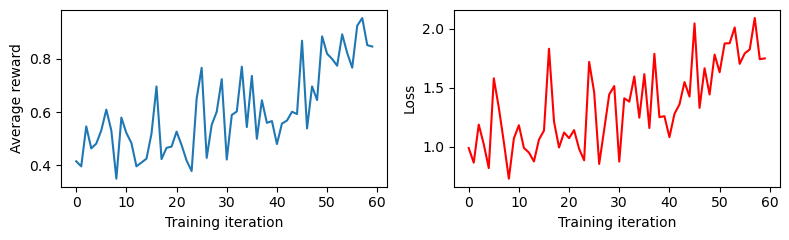

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.27it/s]


Sample trajectories: 100
[0.010, 0.010, 0.813, 2.663]    O=C(OCC1=CC=CC=C1)NC=C2CCCCC2=NC3=CC=CC(F)=C3
[0.120, 0.000, 0.855, 2.876]    O=C1NC2=CC=CC=C2C1C3=CC=C(Br)S3
[0.030, 0.010, 0.808, 4.007]    CNCC=C1CCCCCCCNC2CCC3=CC(OC)=CC=C3C12
[0.020, 0.010, 0.619, 3.308]    C1=COC(=O)C(C12)CCN(CCOCC3=CC=CC=C3)CC2
[0.480, 0.210, 0.420, 2.261]    CC1=NC(NC2=CC=CC=C2)=NC=C1C3=CC(C4=CC=NC=C4)=NC5=CC=CC=C35
[0.000, 0.000, 0.275, 5.216]    O=[N+1][O-1]
[0.010, 0.000, 0.415, 3.068]    CN(C)CC=CCCl
[0.040, 0.010, 0.789, 2.705]    C=C1C2=C(C=CS2)C(NC3=CC=CC=C3)=N1
[0.050, 0.010, 0.718, 5.709]    O=S(=O)(C1=C2C=CC=C1F)NC3C=C=NNC2N=C(COC4=CC=CC=C4)N3
[0.060, 0.020, 0.691, 3.979]    ClC=C1C=CCCOC2=NC=CC=C2N=C1
[0.130, 0.020, 0.760, 4.265]    CCC(C)C1NC(=O)C2=CC=CC3=C2N1C4=NCCN4OC3CCCC5=CC=CC=C5
[0.120, 0.050, 0.816, 4.014]    C1C=NNC(=O)C1=CC(C2=CC=CO2)=C3C=CC=CC3=N
[0.128, 0.090, 0.442, 3.680]    COC=C1C(Cl)=CC(C=C2NC(=O)NC2=O)=C1
[0.040, 0.010, 0.658, 5.000]    CCSC1=CC=C(C2)C=C1C=CN=CCNCC2=C
[0.140, 

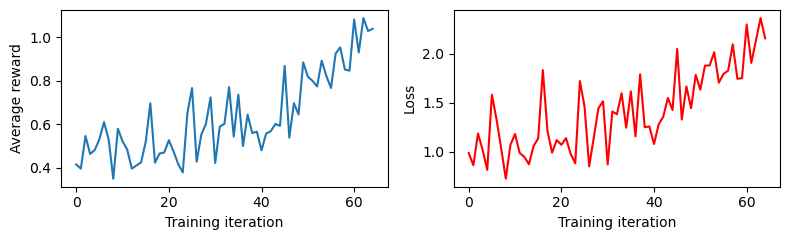

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 366.72it/s]


Sample trajectories: 100
[0.110, 0.020, 0.713, 2.541]    OC1=CC=C(Cl)C=C1C2=NCCN2
[0.100, 0.000, 0.394, 3.167]    O=CNC(C(=O)O)(C1=CC=CN=C1)C(=O)NCCN2CCN(C3=CC=CC=C3)CC2
[0.030, 0.010, 0.711, 4.356]    CC=C1N=C(N)COCCCOC=CC=CC=N1
[0.660, 0.560, 0.768, 2.211]    NC1=NC=CC=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.160, 0.020, 0.544, 2.839]    N1C2=CC=NC=NC2=N1
[0.160, 0.010, 0.723, 4.457]    C12=CNC=CC=NC=C1C(Br)C(C(F)(F)F)=C2
[0.130, 0.060, 0.789, 2.391]    N1N=C1C2=CC=NC(C3=CC=CC=N3)=C2
[0.000, 0.000, 0.647, 4.597]    C12COC(=O)C=CC1(C)CC2(O)C(F)(F)F
[0.020, 0.030, 0.664, 2.848]    COC1=CC=CC=C1NC=C2N=C(C3CCN(C)CC3)C(C4=CC=C(Cl)C=C4Cl)=N2
[0.150, 0.020, 0.604, 2.943]    C1=C(C2=CC=NC(N)=N2)O1
[0.060, 0.000, 0.192, 3.781]    O=C1NC(=O)C(C(C)=NNC(N)=S)N1
[0.040, 0.010, 0.564, 3.558]    O=C(O)CCC(=O)NCC1CCCN(OCC2=CC=CN=C2)C1CNC
[0.000, 0.000, 0.536, 2.124]    NC1=CC=C(Cl)N=C1
[0.020, 0.010, 0.449, 4.689]    C12(C(=O)OC1)C(C)C2O
[0.580, 0.310, 0.826, 2.030]    C1CN1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2

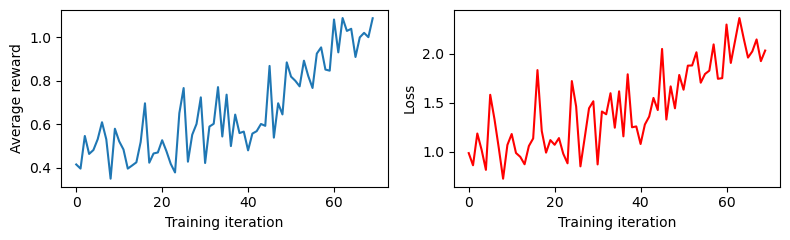

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371.58it/s]


Sample trajectories: 100
[0.050, 0.010, 0.577, 4.623]    C1=CCNC(=S)NN=CC=C1Cl
[0.000, 0.010, 0.633, 2.471]    COCC(=O)OC1=C(Cl)C=CC(Br)=C1CC
[0.810, 0.430, 0.767, 2.624]    CC1=NNC=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.050, 0.000, 0.243, 3.607]    O=CC(CO)=NNCCC=C(Cl)C=CC1=CC=CC(Br)=C1
[0.090, 0.100, 0.674, 2.251]    COC1=NC=C(C(F)(F)F)C=C1C(=O)N(C)CC2=CC=CC3=CC=CC=C23
[0.570, 0.230, 0.826, 1.950]    CC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.000, 0.000, 0.783, 2.700]    O=COC(C1=CC=C(Cl)C=C1Cl)CNCC2=CC=CC=C2
[0.070, 0.020, 0.234, 3.680]    COC=CC=CC(=O)C(C=CC1=CC=CC=C1)=CN(NC(=O)OC)C2=CC(=O)C3=CC4=C(C=C32)OCO4
[0.580, 0.320, 0.715, 2.474]    N#CC(=CC1=CC=CC=C1F)C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.040, 0.010, 0.453, 4.012]    O=C(C1=CC=C(F)C=C1)CCCC2C=CC=CC(S(=O)(=O)CC)=C3CCCCCC3=C2
[0.010, 0.000, 0.385, 3.092]    COC(O)=CC=CC(=O)OC(C)C1=CC=C(F)C=C1
[0.010, 0.010, 0.706, 4.024]    O=C1CCC2C=C1C3=CC4=CC=CC=C4N3C2=O
[0.050, 0.010, 0.495, 2.441]    NC1=CN=CC=N1
[0.060, 0.040, 0.767, 2.119]    O=C(C=

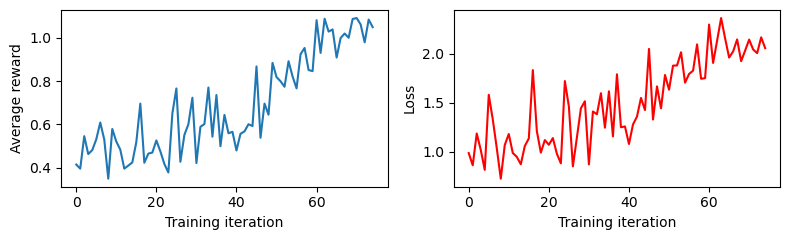

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 399.10it/s]


Sample trajectories: 100
[0.120, 0.030, 0.613, 5.136]    C1NC2=NC(Cl)=NC3=C2N=CN31
[0.200, 0.140, 0.798, 1.904]    C1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.590, 0.310, 0.895, 2.899]    OC1CCCN1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.270, 0.320, 0.808, 2.169]    CCOC(=O)C1=CN=C(NC2CCCCC2)N=C1N
[0.130, 0.040, 0.700, 3.596]    C1C=CC=CC2=C(C3=CC=CN=C3)C(C)=CC12
[0.000, 0.000, 0.569, 1.396]    CC(=O)C1=CC=CC=C1Cl
[0.030, 0.000, 0.469, 5.150]    CC(C(N1)=O)(C23CNCC2C3)N1
[0.050, 0.020, 0.767, 3.233]    C1C=NOC(CCCN2C=CN=C2)=C1SC3=CC=C(Cl)C=C3
[0.650, 0.330, 0.623, 2.198]    CC1=CN=C(NC2=CC=C(C#N)C=C2)N=C1NCC3=CC=C(C(N)=O)C=C3
[0.000, 0.000, 0.511, 2.943]    O=C(O)C=CC(C(F)(F)F)=C(C)SC1=CC=CC=C1
[0.040, 0.030, 0.697, 2.909]    O=C1NN=CC2=C(C3=C(CCCC3)S2)C1=O
[0.720, 0.550, 0.759, 2.484]    NC1=CN=CN=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.000, 0.000, 0.461, 1.659]    C1C2=CC=CC=C21
[0.830, 0.500, 0.794, 1.962]    COC1=CC=CC=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.460, 0.040, 0.698, 2.498]    O=C1NC(=O)C(C2=CNC3=

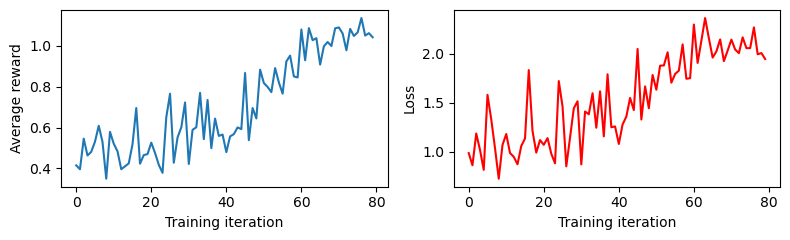

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.39it/s]


Sample trajectories: 100
[0.030, 0.050, 0.738, 2.284]    CNC(=O)C1=CC(N2N=CC(=O)NC2=O)=CC=C1OC3=CC=C(C)C=C3
[0.030, 0.000, 0.424, 2.815]    CC=CC=C(C)C1=CC=NC(SCC2=CC=CC=C2F)=C1CCC
[0.020, 0.010, 0.372, 4.588]    C1C2(Cl)C(=O)NC=CCCN2CC=C1
[0.740, 0.500, 0.708, 2.313]    SCC1=CC=CC=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.170, 0.050, 0.593, 3.938]    CC=C1C=CNC(=O)C(C#CC2CC2)=C1
[0.030, 0.010, 0.471, 4.983]    COC=CC=CC=CCC1COC2OCCC2CCC=NC3=CC=CC=C3S1
[0.040, 0.020, 0.802, 4.323]    CCN(CC)CC1C(=O)C2=CC=C(S2)OC3=CC=C(Cl)C=C31
[0.200, 0.030, 0.424, 2.559]    O=C1NC2=CC=CC=C2C1=NN
[0.610, 0.320, 0.788, 2.112]    NC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.070, 0.010, 0.626, 4.842]    O=C1NC2=CC3=CC=C2C1(O3)C(=O)O
[0.020, 0.020, 0.495, 4.662]    O1N=C1SC=C
[0.760, 0.120, 0.633, 2.337]    O=C1NC(=O)C(C2=CNC3=CC=CC=C23)=C1NCC4=CC=C(Cl)C=C4
[0.190, 0.010, 0.717, 2.066]    O=C1NC2=CC=CC=C2N=C1NC3=CC=NC=C3
[0.010, 0.000, 0.706, 2.997]    O=CC(NC1=CC=CC=C1)CC(O)C2=CC=C(O)C=C2
[0.690, 0.370, 0.931, 3.166]    

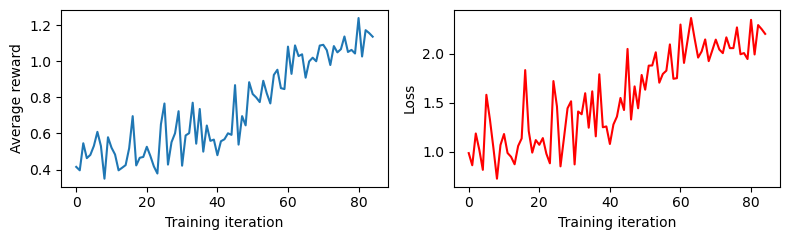

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 386.71it/s]


Sample trajectories: 100
[0.570, 0.230, 0.826, 1.950]    CC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.120, 0.010, 0.782, 3.018]    C1CN=NN1C2=CC=NC(C3=CC=NC=C3)=N2
[0.050, 0.010, 0.490, 3.322]    C=CC(=O)COC(C)C(COCC1=CC=CC=C1)OC(C)=O
[0.040, 0.000, 0.783, 3.904]    CS1C=CC(=O)N2N=C(C3=CC=CC=C3)C=C12
[0.140, 0.130, 0.486, 2.861]    NC1=CC=CC(F)=C1N=CC2=NC(NC3=CC=C(C#N)C=C3)=NC(N)=N2
[0.080, 0.010, 0.774, 3.381]    COC=C1C=C2NC(=O)C(CC3=CC=CC=C3)=C2NC1=C(C)Cl
[0.660, 0.370, 0.909, 3.119]    OC1CCCCC1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.050, 0.010, 0.817, 3.616]    N#CC=C(N)N(C1=CC=C(Br)C=C12)C=NC(C3=CC=CO3)=CC2
[0.020, 0.010, 0.677, 1.985]    CCOC(=O)CNC(=O)CCC(=O)N(C)CC1=CC=CC(C2=CC=CC=C2)=C1
[0.030, 0.010, 0.858, 2.066]    O=C(NC1CC1)C2=CC=CN=C2SCC3=CC=NC=C3
[0.280, 0.010, 0.775, 4.667]    NC1=NC=NC2=C1N=CN2C3C4CCCC3(N)C4
[0.730, 0.520, 0.682, 2.200]    C=CCOC1=CC=CC=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.010, 0.000, 0.673, 2.081]    CC(C)C(=O)C1=CC=C(C2=CN3C=CC=CC3=N2)C=C1
[0.060, 0.000, 0.430, 4.22

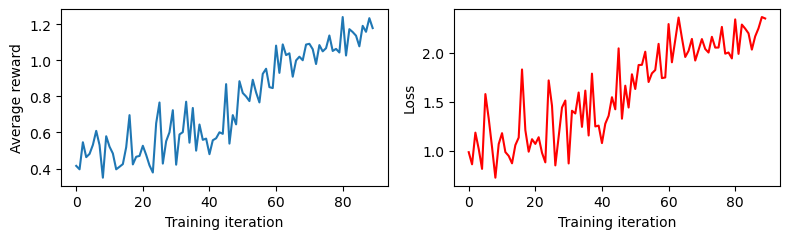

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 390.12it/s]


Sample trajectories: 100
[0.060, 0.030, 0.680, 2.415]    O=C(NCC1=CC=CO1)NC2=NNC(C3=CC=CO3)=C2
[0.000, 0.000, 0.922, 3.095]    O=C1CSC(NCC2=CC=CC(F)=C2)N1CC3=CC=CO3
[0.750, 0.550, 0.768, 2.310]    NC1=CC=CN=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.110, 0.020, 0.733, 2.927]    CC1=CC=CC(C)=C1N=CC2=CC3=C(C=NN3C)C(=O)N2
[0.010, 0.060, 0.563, 3.510]    CCOC(=O)C=C(C1SC2=NC=CN2C)N(C3=CC=CC=C3)N=C1C(C)=O
[0.060, 0.020, 0.571, 3.226]    NC(=O)C=C1C2=CC=C(N(C)C)N=C2OC1=O
[0.610, 0.320, 0.788, 2.112]    NC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.070, 0.010, 0.518, 3.875]    N1C=CC=CC=C1C=O
[0.460, 0.120, 0.603, 2.200]    COC1=CC=C2NC=C(C2=C1)C3=CC=NC(CC4=CC=C(F)C=C4)=N3
[0.030, 0.000, 0.668, 2.033]    NCCSC(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3
[0.000, 0.030, 0.516, 2.625]    N#CCCC1=NC=CC=C1[N+1](=O)[O-1]
[0.130, 0.030, 0.741, 2.940]    COC1=CC(C=CC(=O)O)=C(OC)C2=C1C3=C(CCCN3)C(=O)N2
[0.060, 0.070, 0.712, 2.535]    OC1=NC2=CC(Cl)=CN=C2C(O)=C1C3=CC=CC=C3Cl
[0.050, 0.000, 0.703, 3.474]    C1CNCCNC=NC2=CC=C(Cl

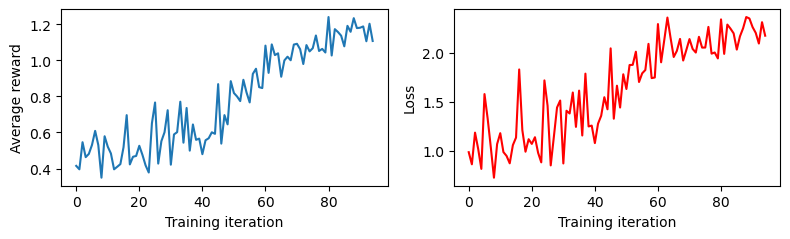

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 433.02it/s]


Sample trajectories: 100
[0.040, 0.000, 0.527, 2.149]    S=C(NCC1=CC=NC=C1)C(=O)OC2=CC=CC=C2
[0.010, 0.010, 0.235, 3.409]    N(O)C=O
[0.030, 0.010, 0.825, 3.074]    N1C=CC=NC(SCC2=CC=CC=C2)=N1
[0.010, 0.080, 0.628, 3.638]    C1C2CC1C=CN2S(=O)(=O)CC3=CC=CC([N+1](=O)[O-1])=C3
[0.750, 0.430, 0.619, 2.352]    CCN(C)CCNC1=CC=CC=C1C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.010, 0.010, 0.858, 3.769]    CC=C1OCOC1(SCC2=CC=C(Cl)C=C2)N
[0.050, 0.010, 0.514, 3.558]    N#CC(C#N)=C1C=CC=CN1
[0.570, 0.230, 0.826, 1.950]    CC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.110, 0.020, 0.678, 3.130]    N1C=CC=CC2=C1N3CCOCC3=NC4=CC=C(Br)C=C24
[0.570, 0.230, 0.826, 1.950]    CC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.020, 0.010, 0.584, 5.747]    O1C(=O)C2CCC2S1CC
[0.010, 0.030, 0.598, 4.653]    C1C=NN2C1(C)C(Br)=CC2=O
[0.000, 0.000, 0.398, 3.364]    N1=C(N)O1
[0.020, 0.000, 0.482, 2.901]    CCCCC=C(C)N=C(C(F)(F)F)C1=CC(Cl)=CC=C1
[0.080, 0.010, 0.723, 3.523]    NC1C2=NOC(C)=C2C3=CC=CC=C3NC=N1
[0.050, 0.000, 0.398, 2.912]    NC(=O)C(CCC

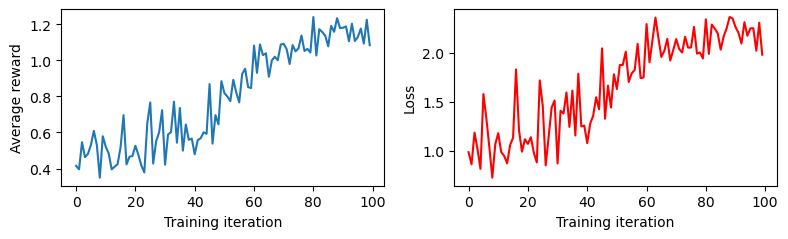

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 398.21it/s]


Sample trajectories: 100
[0.570, 0.230, 0.826, 1.950]    CC1=CC=NC(NC2=CC=C(C#N)C=C2)=N1
[0.000, 0.000, 0.704, 3.395]    C1=CC(OCCCC(=O)O)=CC=C1OCC23CC4CC(CC(C4)C2)C3
[0.040, 0.030, 0.799, 2.273]    NC1=NN=C(NC2=CC=C(C#N)C=C2)S1
[0.020, 0.010, 0.877, 3.240]    N#CC(=CC1=CC=C(Cl)C=C12)NC(=O)C(C3=CC=CC=C3)O2
[0.000, 0.010, 0.569, 2.141]    CC1=CC=NC(C(F)(F)F)=C1
[0.100, 0.070, 0.519, 3.888]    CN1C=C2C=C1OC3=CC=CN=C23
[0.530, 0.230, 0.777, 2.099]    CN(CC1=CC=CC=C1)C2=CC=NC(NC3=CC=C(C#N)C=C3)=N2
[0.050, 0.060, 0.261, 2.838]    CCNC1=NC=CC=C1CCCCCCCC=CC=C[N+1](=O)[O-1]
[0.020, 0.040, 0.309, 3.175]    CCOC=CC(NN=CC1=CC=CC=C1F)=NC(NC2=CC=C(C#N)C=C2)=N
[0.120, 0.070, 0.283, 3.056]    COC(=O)C=C(C)N=C(C1=CC=CC(F)=C1)N=CNC2=CC=C(N)C=C2
[0.060, 0.010, 0.446, 2.770]    O=CC=CC1=CC2=C(OCC3=CC=CN=C3)C=CC=C2N1O
[0.020, 0.050, 0.935, 1.724]    NC(=O)C1=CC(Cl)=C(Cl)C=C1OCC2=CC=CC=C2
[0.040, 0.000, 0.804, 4.998]    OC#CCN1CC2CC1(CC3=CC=CC=C3)C=C4C=C(OC)C(OC)=CC4=N2
[0.290, 0.360, 0.771, 2.053]    N#CC

In [21]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

gsk_list = []
jnk_list = []
qed_list = []
sa_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.1
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(grad_clipping=1., alpha=alpha)
    
    ## append - reward
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_gsk = 0.
    avg_jnk = 0.
    avg_qed = 0.
    avg_sa = 0.
    
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, s_gsk, s_jnk, s_qed, s_sa = my_reward_ft(sm, debug=True)
                print(f"[{s_gsk:.3f}, {s_jnk:.3f}, {s_qed:.3f}, {s_sa:.3f}]    {sm}")
                avg_gsk += s_gsk
                avg_jnk += s_jnk
                avg_qed += s_qed
                avg_sa += s_sa
            avg_gsk /= len(smiles_cur)
            avg_jnk /= len(smiles_cur)
            avg_qed /= len(smiles_cur)
            avg_sa /= len(smiles_cur)
    
    ## append - binding affinity values
    gsk_list.append(avg_gsk)
    jnk_list.append(avg_jnk)
    qed_list.append(avg_qed)
    sa_list.append(avg_sa)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                      gsk_list, jnk_list, qed_list, sa_list,
                      execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [22]:
ReBADD.generator.save_model(model_path)

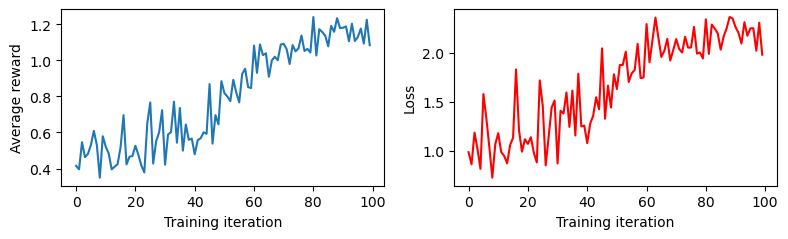

In [23]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [24]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                           gsk_list, jnk_list, qed_list, sa_list,
                           execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(100, 9)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY    GSK3   JNK3      QED  \
0  0.415230  0.986773      0.911657      0.075116  0.0000  0.000  0.00000   
1  0.396189  0.862743      0.775582      0.087161  0.0000  0.000  0.00000   
2  0.546091  1.186223      1.095253      0.090970  0.0000  0.000  0.00000   
3  0.463522  1.019603      0.922736      0.096867  0.0000  0.000  0.00000   
4  0.481530  0.816177      0.707174      0.109002  0.0594  0.018  0.58809   

         SA   EXEC_TIME  
0  0.000000   30.633208  
1  0.000000   60.734561  
2  0.000000   91.325102  
3  0.000000  121.804417  
4  3.521231  152.159895  


In [25]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [26]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:13<00:00, 410.41it/s]


In [27]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize/smi_after.csv
